# **Description**<br>
While the rate of fatal road accidents has been decreasing steadily since the 80s, the past ten years have seen a stagnation in this reduction. Coupled with the increase in number of miles driven in the nation, the total number of traffic related-fatalities has now reached a ten year high and is rapidly increasing.By looking at the demographics of traﬃc accident victims for each US state, we find that there is a lot of variation between states. Now we want to understand if there are patterns in this variation in order to derive suggestions for a policy action plan. In particular, instead of implementing a costly nation-wide plan we want to focus on groups of states with similar profiles.

# Import Libraries 

In [1]:
import pandas as pd
import numpy as np
# Import label encoder
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
#Pair Plot Graph
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
# Standardize and center the feature columns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#**Project Task**<br>


*   The raw data files and their format
*   Read in and get an overview of the data


*   Create a textual and a graphical summary of the data

*   Quantify the association of features and accidents

*   Fit a multivariate linear regression

*   Perform PCA on standardized data

*   Visualize the first two principal components

*   Find clusters of similar states in the data
*   KMeans to visualize clusters in the PCA scatter plot


*   Visualize the feature differences between the clusters


*  Compute the number of accidents within each cluster

*   Make a decision when there is no clear right choice





# Read in and get an overview of the data


In [2]:
#import the miles driven dataset
dataset_road_acc=pd.read_csv('/content/road-accidents.csv' , comment ="#", delimiter='|')
print(dataset_road_acc)

                   state  drvr_fatl_col_bmiles  perc_fatl_speed  \
0                Alabama                  18.8               39   
1                 Alaska                  18.1               41   
2                Arizona                  18.6               35   
3               Arkansas                  22.4               18   
4             California                  12.0               35   
5               Colorado                  13.6               37   
6            Connecticut                  10.8               46   
7               Delaware                  16.2               38   
8   District of Columbia                   5.9               34   
9                Florida                  17.9               21   
10               Georgia                  15.6               19   
11                Hawaii                  17.5               54   
12                 Idaho                  15.3               36   
13              Illinois                  12.8               3

In [3]:
#columns name of dataset_road_acc
print(dataset_road_acc.columns)

Index(['state', 'drvr_fatl_col_bmiles', 'perc_fatl_speed', 'perc_fatl_alcohol',
       'perc_fatl_1st_time'],
      dtype='object')


# Data Pre-processing

In [4]:
#find the null values 
dataset_road_acc.isnull().sum()

state                   0
drvr_fatl_col_bmiles    0
perc_fatl_speed         0
perc_fatl_alcohol       0
perc_fatl_1st_time      0
dtype: int64

In [5]:
#shape of Dataset
dataset_road_acc.shape

(51, 5)

No of Rows : 51 <br>
no of columns : 5

In [6]:
# Encode labels in column 'state'.
dataset_road_acc['state']= label_encoder.fit_transform(dataset_road_acc['state'])
dataset_road_acc['state'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

# Graphical Summary

In [7]:
dataset_road_acc

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
0,0,18.8,39,30,80
1,1,18.1,41,25,94
2,2,18.6,35,28,96
3,3,22.4,18,26,95
4,4,12.0,35,28,89
5,5,13.6,37,28,95
6,6,10.8,46,36,82
7,7,16.2,38,30,99
8,8,5.9,34,27,100
9,9,17.9,21,29,94


We now have an idea of what the dataset looks like. To further familiarize ourselves with this data, we will calculate summary statistics and produce a graphical overview of the data. The graphical overview is good to get a sense for the distribution of variables within the data and could consist of one histogram per column. It is often a good idea to also explore the pairwise relationship between all columns in the data set by using a using pairwise scatter plots (sometimes referred to as a "scatterplot matrix").

**Pair Plots Graph**

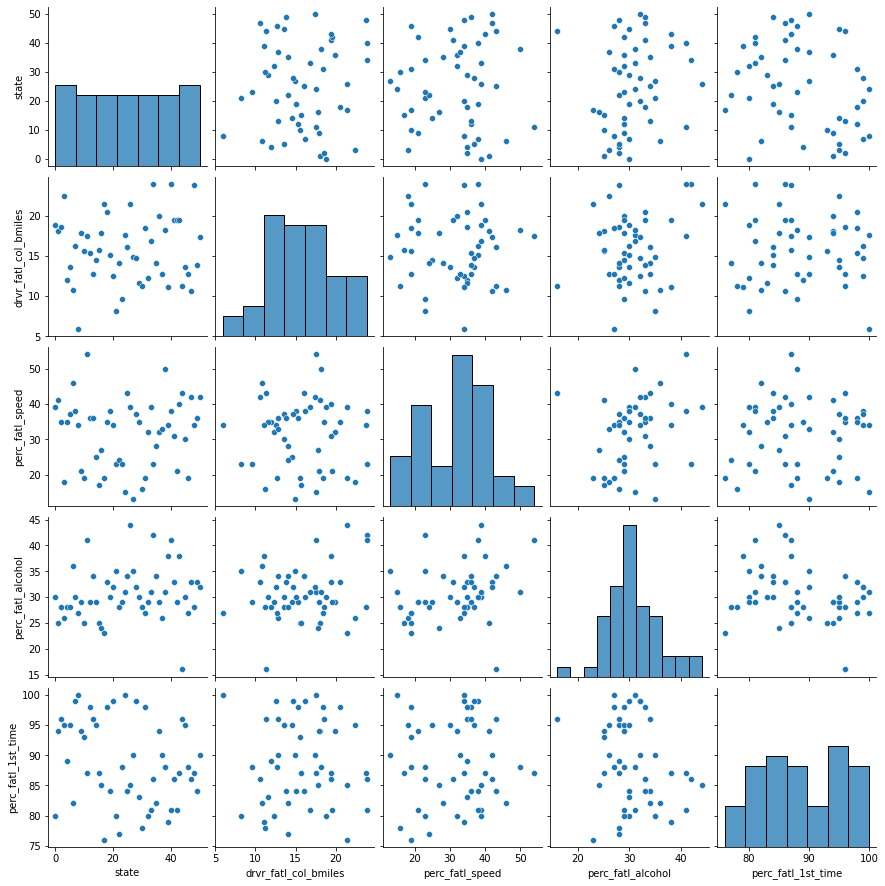

In [8]:
sns.pairplot(dataset_road_acc)

# Quantify the association of features and accidents

To quantify the pairwise relationships that we observed in the scatter plots, we can compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:<br>
*   0.2 = weak
*   0.5 = medium

*   0.8 = strong
*   0.9 = very strong

In [9]:
dataset_road_acc.corr()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
state,1.000000,0.058292,0.032120,0.176156,-0.271191
drvr_fatl_col_bmiles,0.058292,1.000000,-0.029080,0.199426,-0.017942
perc_fatl_speed,0.032120,-0.029080,1.000000,0.286244,0.014066
perc_fatl_alcohol,0.176156,0.199426,0.286244,1.000000,-0.245455
perc_fatl_1st_time,-0.271191,-0.017942,0.014066,-0.245455,1.000000


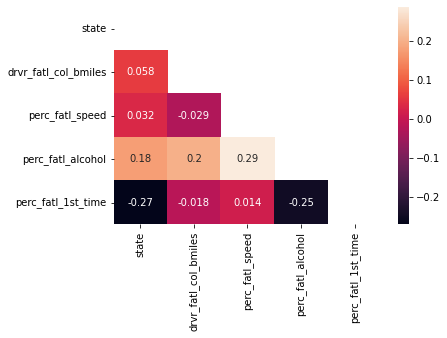

In [10]:
corr= dataset_road_acc.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

In [11]:
X=dataset_road_acc.drop(columns=['state'] , axis=1)
Y=dataset_road_acc['state']

# Fit a multivariate linear regression

**bold text**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .75)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38, 4)
(13, 4)
(38,)
(13,)


In [14]:
# Import the linear model function from sklearn
from sklearn import linear_model

# Create the features and target DataFrames
features = dataset_road_acc[["perc_fatl_speed",
                    "perc_fatl_alcohol", "perc_fatl_1st_time"]]
target = dataset_road_acc["drvr_fatl_col_bmiles"]

# Create a linear regression object
reg = linear_model.LinearRegression()

# Fit a multivariate linear regression model
reg.fit(X=features, y=target)

# Retrieve the regression coefficients
fit_coef = reg.coef_
fit_coef

array([-0.04180041,  0.19086404,  0.02473301])

# Perform PCA on standardized data

In [15]:

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Import the PCA class function from sklearn
pca = PCA()

# Fit the standardized data to the pca
pca.fit(features_scaled)

PCA()

# Visualize the first two principal components

The cumulative variance of the first two principal components is 0.7947


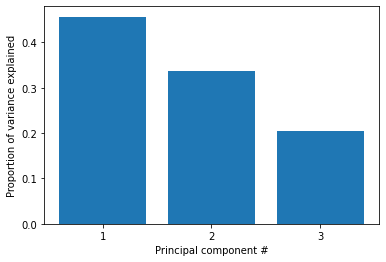

In [16]:
# Plot the proportion of variance explained on the y-axis of the bar plot
plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
plt.xlabel('Principal component #')
plt.ylabel('Proportion of variance explained')
plt.xticks([1, 2, 3])

# Compute the cumulative proportion of variance explained by the first two principal components
two_first_comp_var_exp = pca.explained_variance_ratio_.cumsum()[1]
print("The cumulative variance of the first two principal components is {}".format(
    round(two_first_comp_var_exp, 5)))